# Training PGGANs on the LiTS datasets - train

- [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://github.com/tkarras/progressive_growing_of_gans)

## 1. TrainingJob 생성

- [EstimatorBase](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html?highlight=estimatorBase)
- [Sagemaker Tensorflow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html)
- [Inputs](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html)
- [Amazon SageMaker, 배치 변환 기능 및 TensorFlow 컨테이너를 위한 파이프 입력 모드 추가](https://aws.amazon.com/ko/blogs/korea/amazon-sagemaker-adds-batch-transform-feature-and-pipe-input-mode-for-tensorflow-containers/)
- [sagemaker-tensorflow-extensions](https://github.com/aws/sagemaker-tensorflow-extensions)

In [29]:
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker import get_execution_role

In [30]:
BUCKET_NAME = "sagemaker-jhgan-workspace" # 결과를 저장할 버킷
JOB_NAME = "pggan-LiTS-window-level-128batch"
S3_OUTPUT_LOCATION = f's3://{BUCKET_NAME}'
DOCKER_IMAGE_URI = "349048005035.dkr.ecr.us-east-2.amazonaws.com/pggan:1.15.3-gpu-py3"
VOLUME_SIZE = 50
INSTANCE_COUNT = 1
INSTANCE_TYPE = "ml.p3.16xlarge"
FRAMEWORK_VERSION = "1.15.3"
PY_VERSION = "py3"
MAX_TRAINING_TIME = 86400

print(f"S3 Output Path: {S3_OUTPUT_LOCATION}")

S3 Output Path: s3://sagemaker-jhgan-workspace


In [31]:
estimator = TensorFlow(
    entry_point = "train.py",
    image_name = DOCKER_IMAGE_URI,
    role = get_execution_role(),
    output_path=S3_OUTPUT_LOCATION,
    train_instance_count=INSTANCE_COUNT,
    train_instance_type=INSTANCE_TYPE,
    train_volume_size=VOLUME_SIZE,
    framework_version=FRAMEWORK_VERSION,
    py_version=PY_VERSION,
    source_dir = "./",
    train_max_run = MAX_TRAINING_TIME
)

In [ ]:
estimator.fit(job_name=JOB_NAME)

## 2. 스냅샷 점검

In [27]:
import tarfile
import os
import boto3
from PIL import Image
from IPython.display import display

import dataset
import config
import misc
from train import *

### 2.1. 학습결과 다운로드

In [ ]:
s3 = boto3.client('s3')
objs = ["model", "output"]
JOB_NAME = "pggan-LiTS-window-uint-800lod"
for obj in objs:
    if not os.path.isdir(obj): os.mkdir(obj)
    s3_path = f"{JOB_NAME}/output/{obj}.tar.gz"
    local_path = f'{obj}/{obj}.tar.gz'
    with open(local_path, 'wb') as f:
        s3.download_fileobj(BUCKET_NAME, s3_path, f)
    tar = tarfile.open(local_path, "r:gz")
    for tarinfo in tar:
        tar.extract(tarinfo, obj)

### 2.2. 이미지 스냅샷

In [19]:
import matplotlib.pyplot as plt

In [20]:
def display_img(directory="output"):
    fakes = filter(lambda fname: fname[0]=="f", os.listdir(directory))
    paths = sorted([os.path.join(directory, fake) for fake in iter(fakes)])
    
    # n = len(paths)
    
    plt.figure(figsize = (15, 10 * 5))
    for i in range(5):
        plt.subplot(5, 1, i+1)
        fname = paths[-i]
        img = plt.imread(fname)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(fname[-9:])

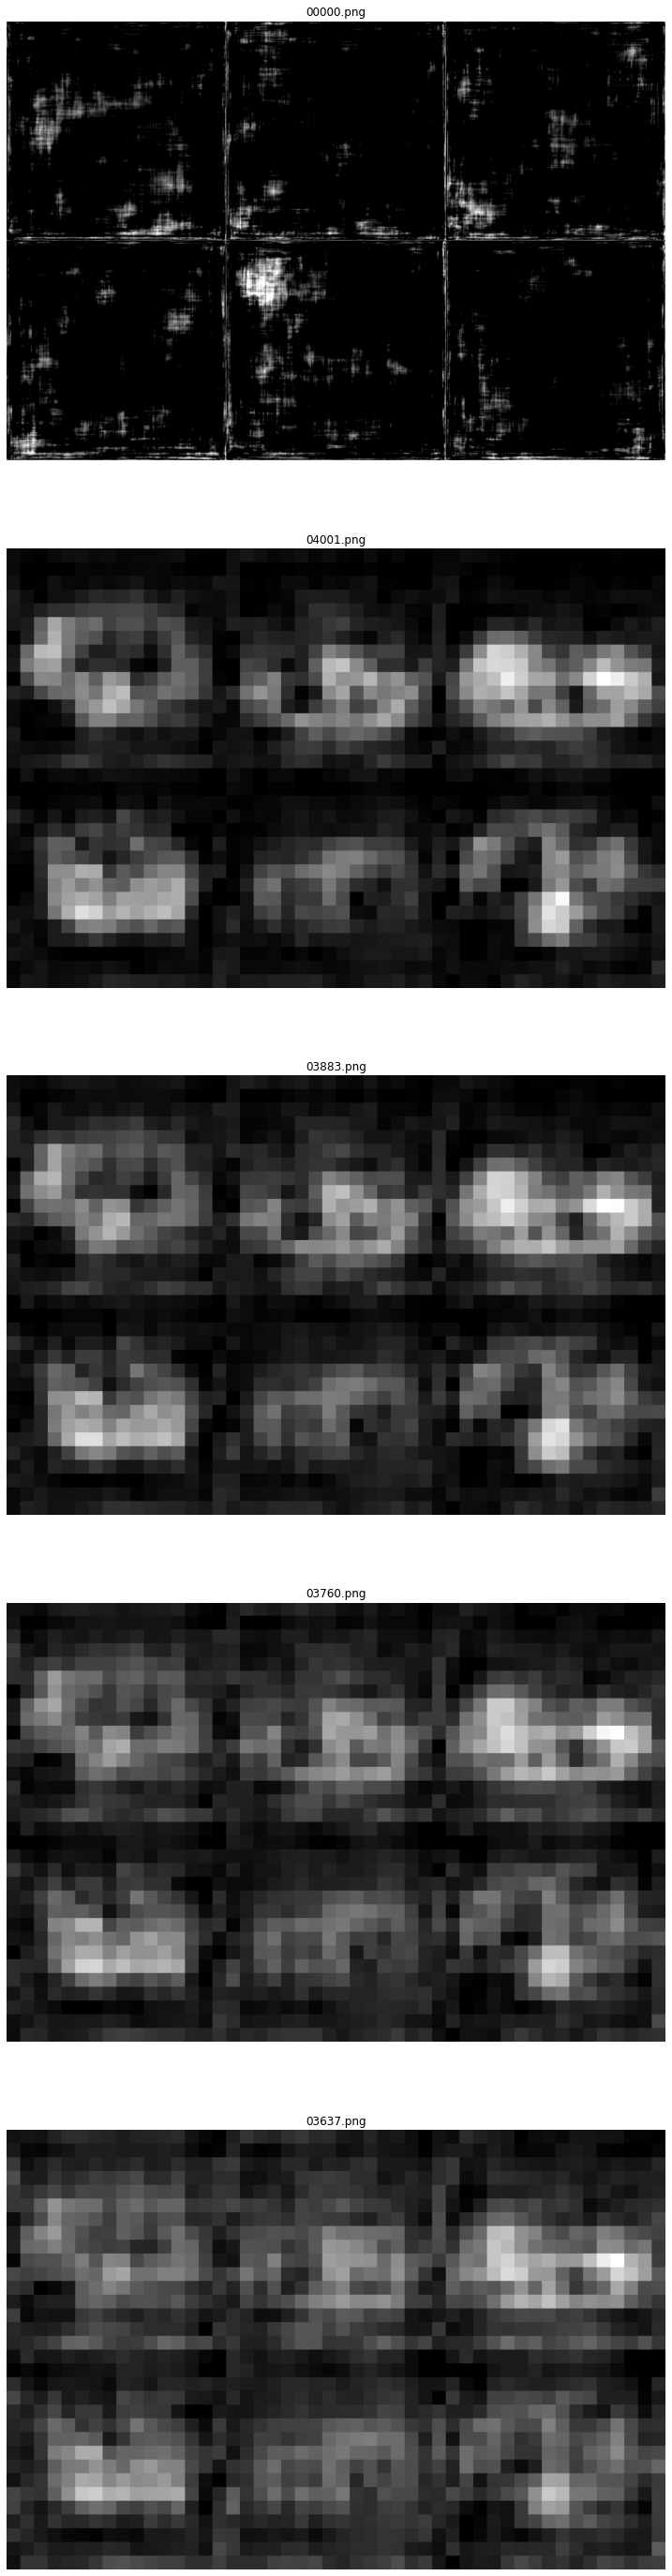

In [21]:
display_img()

### 2.3. 네트워크 스냅샷

In [2]:
import tensorflow as tf
import pickle
import misc

In [6]:
model_dir = "model/000-pgan-LiTS-preset-v2-8gpus-fp32"
models = sorted([fname for fname in os.listdir(model_dir) if fname.split(".")[-1]=="pkl"])
latest_model = models[-1]
print(latest_model)

network-snapshot-007405.pkl


In [ ]:
with tf.Session() as sess:
    print(f"Loading Networks: {latest_model}")
    with open(f"{model_dir}/{latest_model}", 'rb') as file:
        G, D, Gs = pickle.load(file)
    
    print("Done")
    gw = np.clip(1920 // G.output_shape[3], 3, 32)
    gh = np.clip(1080 // G.output_shape[2], 2, 32)

    latents = misc.random_latents(gw * gh, G)
    labels = np.zeros([gw * gh, 0], dtype=np.int64)

    print("Generating Fakes Images ...")
    grid_fakes = Gs.run(latents, labels, minibatch_size=2)
    print("Done")

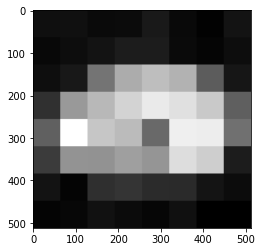

In [27]:
plt.imshow(grid_fakes[0][0], cmap="gray")

## 3. 스냅샷 복원

In [16]:
local_path = f"{model_dir}/{latest_model}"
s3_path = f"model-snapshot/{latest_model}"

In [13]:
s3 = boto3.client('s3')
with open(local_path, "rb") as f:
    s3.upload_fileobj(f, BUCKET_NAME, s3_path)

In [17]:
BUCKET_NAME = "sagemaker-jhgan-workspace" # 결과를 저장할 버킷
JOB_NAME = "pggan-LiTS-restore-07405-V100"
S3_OUTPUT_LOCATION=f's3://{BUCKET_NAME}'
DOCKER_IMAGE_URI = "349048005035.dkr.ecr.us-east-2.amazonaws.com/pggan:1.15.3-gpu-py3"
VOLUME_SIZE = 200
INSTANCE_COUNT = 1
INSTANCE_TYPE = "ml.p3.16xlarge"
FRAMEWORK_VERSION = "1.15.3"
PY_VERSION = "py3"
MAX_TRAINING_TIME = 86400
print(f"S3 Output Path: {S3_OUTPUT_LOCATION}")

S3 Output Path: s3://sagemaker-jhgan-workspace


In [18]:
inputs = {"snapshot":f"s3://{BUCKET_NAME}/model-snapshot/"}

In [19]:
estimator = TensorFlow(
    entry_point = "train.py",
    image_name = DOCKER_IMAGE_URI,
    role = get_execution_role(),
    output_path=S3_OUTPUT_LOCATION,
    train_instance_count=INSTANCE_COUNT,
    train_instance_type=INSTANCE_TYPE,
    train_volume_size=VOLUME_SIZE,
    framework_version=FRAMEWORK_VERSION,
    py_version=PY_VERSION,
    source_dir = "./",
    train_max_run = MAX_TRAINING_TIME
)

In [ ]:
estimator.fit(inputs = inputs, job_name=JOB_NAME)